# Multi-class Disease Type Prediction

## Data Import

In [2]:
# import libraries
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier

In [4]:
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Altair version:', alt.__version__)
print('Sklearn version:', sklearn.__version__)

Numpy version: 1.26.4
Pandas version: 2.1.4
Altair version: 5.0.1
Sklearn version: 1.1.3


In [7]:
# Data card: https://www.kaggle.com/datasets/ehababoelnaga/anemia-types-classification/data

In [9]:
# Data dictionary:
# HGB: The amount of hemoglobin in the blood, crucial for oxygen transport.
# PlT: The number of platelets in the blood, involved in blood clotting.
# WBC: The count of white blood cells, vital for immune response.
# RBC: The count of red blood cells, responsible for oxygen transport.
# MCV (Mean Corpuscular Volume): Average volume of a single red blood cell.
# MCH (Mean Corpuscular Hemoglobin): Average amount of hemoglobin per red blood cell.
# MCHC (Mean Corpuscular Hemoglobin Concentration): Average concentration of hemoglobin in red blood cells.
# PDW: a measurement of the variability in platelet size distribution in the blood
# PCT: A procalcitonin test can help your health care provider diagnose if you have sepsis from a bacterial infection or if you have a high risk of developing sepsis
# LYMp: Percentage of lymphocytes
# NEUTp: Percentage of neutrophils
# LYMn: Absolute lymphocyte count
# NEUTn: Absolute neutrophil count
# Diagnosis: Anemia type based on the CBC parameters

In [13]:
# import dataset and remove duplicate rows
df = pd.read_csv('diagnosed_cbc_data.csv')
df = df.drop_duplicates()

In [15]:
df.head()

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,10.0,43.2,50.1,4.3,5.0,2.77,7.3,24.2,87.7,26.3,30.1,189.0,12.5,0.17,Normocytic hypochromic anemia
1,10.0,42.4,52.3,4.2,5.3,2.84,7.3,25.0,88.2,25.7,20.2,180.0,12.5,0.16,Normocytic hypochromic anemia
2,7.2,30.7,60.7,2.2,4.4,3.97,9.0,30.5,77.0,22.6,29.5,148.0,14.3,0.14,Iron deficiency anemia
3,6.0,30.2,63.5,1.8,3.8,4.22,3.8,32.8,77.9,23.2,29.8,143.0,11.3,0.12,Iron deficiency anemia
4,4.2,39.1,53.7,1.6,2.3,3.93,0.4,316.0,80.6,23.9,29.7,236.0,12.8,0.22,Normocytic hypochromic anemia


In [17]:
# inspect data size (# instances, # attributes)
df.shape

(1232, 15)

In [19]:
# inspect attributes
df.columns

Index(['WBC', 'LYMp', 'NEUTp', 'LYMn', 'NEUTn', 'RBC', 'HGB', 'HCT', 'MCV',
       'MCH', 'MCHC', 'PLT', 'PDW', 'PCT', 'Diagnosis'],
      dtype='object')

In [21]:
# look at counts for each type
# caveat: typically want a balanced dataset in terms of classes for machine learning
# but since we have such a small dataset in this case, don't want to exclude more data than we need
Counter(df.Diagnosis)

Counter({'Healthy': 323,
         'Normocytic hypochromic anemia': 271,
         'Normocytic normochromic anemia': 255,
         'Iron deficiency anemia': 184,
         'Thrombocytopenia': 72,
         'Other microcytic anemia': 56,
         'Leukemia': 44,
         'Macrocytic anemia': 16,
         'Leukemia with thrombocytopenia': 11})

In [23]:
# drop scientifically improbable data
df = df.drop(df[df['HGB'] < 0].index[0])
df = df.drop(df[df['MCV'] < 0].index[0])

In [25]:
cor = df.select_dtypes(include='number').corr()

<Axes: >

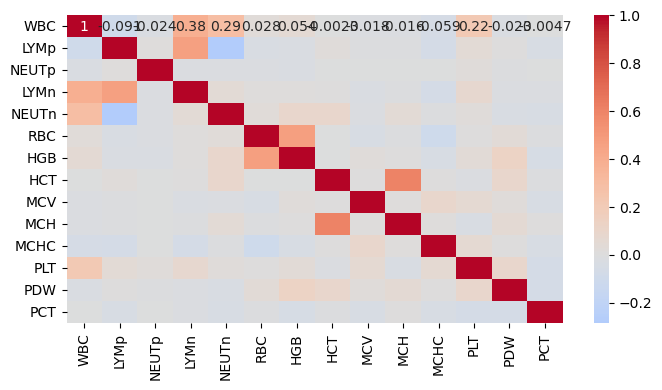

In [29]:
plt.figure(figsize=(8, 4))
sns.heatmap(cor, annot=True, cmap='coolwarm', center=0)

## Logistic Regression

In [32]:
# drop target column for prediction
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

In [34]:
# split into training and testing data
# stratify maintains target class proportions in splits
X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=7, #reproduce the results
                                                    stratify=y      #preserve the distribution of the labels
                                                   )

In [36]:
# scale data for varying attribute ranges
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
# initiliaze logistic regression model
logreg = OneVsRestClassifier(LogisticRegression())

In [40]:
# cross validated scores
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)

In [41]:
# indicate how model performs across different folds, consistency indicates model stability
cv_scores

array([0.67052023, 0.80232558, 0.70348837, 0.70348837, 0.72674419])

In [44]:
# C: regularization strength, larger values fit better to training set but lead to overfitting,
# larger values prioritize simplicity and prevent overfitting

# Penalty: type of regularization, L1 useful when we predict some features may not be useful to training,
# L2 preferred when wanting to maintain all features

# Solver: Algorithm used for optimization, newton-cg and lbfgs generally better for larger datasets,
# liblinear better for small datasets

In [46]:
# hyperparameter tuning for logistic regression
lr_params = [
    {'estimator__C': [100, 10, 1.0, 0.1, 0.01],
     'estimator__penalty': ['l2'],
     'estimator__solver': ['newton-cg', 'lbfgs']},

    {'estimator__C': [100, 10, 1.0, 0.1, 0.01],
     'estimator__penalty': ['l1', 'l2'],
     'estimator__solver': ['liblinear']}
]

In [48]:
# search for model with best hyperparameters and cross validate the model
# refit fits on whole training data, verbose prints output, cv are cross validation folds
lr_grid = GridSearchCV(logreg, lr_params, refit=True, verbose=3, cv=5,
                       return_train_score=True)

# fitting the model for grid search
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=newton-cg;, score=(train=0.773, test=0.688) total time=   0.6s
[CV 2/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=newton-cg;, score=(train=0.742, test=0.808) total time=   0.5s
[CV 3/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=newton-cg;, score=(train=0.756, test=0.733) total time=   0.6s
[CV 4/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=newton-cg;, score=(train=0.798, test=0.703) total time=   0.5s
[CV 5/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=newton-cg;, score=(train=0.763, test=0.733) total time=   0.3s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

[CV 1/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=lbfgs;, score=(train=0.773, test=0.688) total time=   0.4s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=lbfgs;, score=(train=0.742, test=0.808) total time=   0.4s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

[CV 3/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=lbfgs;, score=(train=0.759, test=0.733) total time=   0.4s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

[CV 4/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=lbfgs;, score=(train=0.798, test=0.703) total time=   0.5s
[CV 5/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=lbfgs;, score=(train=0.763, test=0.733) total time=   0.4s
[CV 1/5] END estimator__C=10, estimator__penalty=l2, estimator__solver=newton-cg;, score=(train=0.772, test=0.688) total time=   0.4s
[CV 2/5] END estimator__C=10, estimator__penalty=l2, estimator__solver=newton-cg;, score=(train=0.742, test=0.808) total time=   0.4s
[CV 3/5] END estimator__C=10, estimator__penalty=l2, estimator__solver=newton-cg;, score=(train=0.749, test=0.744) total time=   0.4s
[CV 4/5] END estimator__C=10, estimator__penalty=l2, estimator__solver=newton-cg;, score=(train=0.775, test=0.686) total time=   0.5s
[CV 5/5] END estimator__C=10, estimator__penalty=l2, estimator__solver=newton-cg;, score=(train=0.752, test=0.715) total time=   0.4s
[CV 1/5] END estimator__C=10, estimator__penalty=l2, estimator__solv

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END estimator__C=100, estimator__penalty=l1, estimator__solver=liblinear;, score=(train=0.804, test=0.721) total time=   1.5s
[CV 5/5] END estimator__C=100, estimator__penalty=l1, estimator__solver=liblinear;, score=(train=0.761, test=0.721) total time=   0.5s
[CV 1/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=liblinear;, score=(train=0.772, test=0.688) total time=   0.0s
[CV 2/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=liblinear;, score=(train=0.740, test=0.808) total time=   0.0s
[CV 3/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=liblinear;, score=(train=0.758, test=0.733) total time=   0.1s
[CV 4/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=liblinear;, score=(train=0.798, test=0.709) total time=   0.0s
[CV 5/5] END estimator__C=100, estimator__penalty=l2, estimator__solver=liblinear;, score=(train=0.763, test=0.733) total time=   0.0s
[CV 1/5] END estimator__C=10, estimator__penalty=l1, es

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END estimator__C=10, estimator__penalty=l1, estimator__solver=liblinear;, score=(train=0.800, test=0.721) total time=   1.6s
[CV 5/5] END estimator__C=10, estimator__penalty=l1, estimator__solver=liblinear;, score=(train=0.769, test=0.727) total time=   0.3s
[CV 1/5] END estimator__C=10, estimator__penalty=l2, estimator__solver=liblinear;, score=(train=0.773, test=0.671) total time=   0.1s
[CV 2/5] END estimator__C=10, estimator__penalty=l2, estimator__solver=liblinear;, score=(train=0.733, test=0.802) total time=   0.0s
[CV 3/5] END estimator__C=10, estimator__penalty=l2, estimator__solver=liblinear;, score=(train=0.750, test=0.744) total time=   0.0s
[CV 4/5] END estimator__C=10, estimator__penalty=l2, estimator__solver=liblinear;, score=(train=0.772, test=0.686) total time=   0.0s
[CV 5/5] END estimator__C=10, estimator__penalty=l2, estimator__solver=liblinear;, score=(train=0.746, test=0.703) total time=   0.0s
[CV 1/5] END estimator__C=1.0, estimator__penalty=l1, estimato

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             param_grid=[{'estimator__C': [100, 10, 1.0, 0.1, 0.01],
                          'estimator__penalty': ['l2'],
                          'estimator__solver': ['newton-cg', 'lbfgs']},
                         {'estimator__C': [100, 10, 1.0, 0.1, 0.01],
                          'estimator__penalty': ['l1', 'l2'],
                          'estimator__solver': ['liblinear']}],
             return_train_score=True, verbose=3)

In [49]:
# # print best parameter after tuning
print(lr_grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(lr_grid.best_estimator_)

# print the best score
print(lr_grid.best_score_)

{'estimator__C': 100, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
OneVsRestClassifier(estimator=LogisticRegression(C=100, penalty='l1',
                                                 solver='liblinear'))
0.7387216023659093


In [50]:
 # fit the data with the best estimator with the best parameters
lr_grid.best_estimator_.fit(X_train, y_train)

# predict
y_pred = lr_grid.best_estimator_.predict(X_test)

In [51]:
print(classification_report(y_test, y_pred))

                                precision    recall  f1-score   support

                       Healthy       0.75      0.85      0.79        97
        Iron deficiency anemia       0.84      0.93      0.88        55
                      Leukemia       0.44      0.31      0.36        13
Leukemia with thrombocytopenia       0.50      0.33      0.40         3
             Macrocytic anemia       0.50      0.40      0.44         5
 Normocytic hypochromic anemia       0.70      0.74      0.72        81
Normocytic normochromic anemia       0.72      0.63      0.67        76
       Other microcytic anemia       0.67      0.12      0.20        17
              Thrombocytopenia       0.56      0.68      0.61        22

                      accuracy                           0.72       369
                     macro avg       0.63      0.55      0.56       369
                  weighted avg       0.71      0.72      0.70       369



## Decision Tree

In [57]:
# criterion used to measure quality of split, entropy measures uncertainty in dataset,
# gini is probability randomly selected node would be categorized incorrectly, try to minimize both

# max depth is the number of levels allowed in decision tree
hyperparams = {'estimator__criterion': ['entropy', 'gini'],
              'estimator__max_depth': [3,4,5,6,7,8,9,10]}

In [59]:
dt = OneVsRestClassifier(DecisionTreeClassifier())

In [61]:
cv_scores = cross_val_score(dt, X_train, y_train, cv=5)

In [63]:
cv_scores

array([0.94219653, 0.97093023, 0.95930233, 0.97093023, 0.97093023])

In [67]:
dt_grid = GridSearchCV(dt, hyperparams, refit=True, verbose=3, cv=5,
                       return_train_score=True)
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END estimator__criterion=entropy, estimator__max_depth=3;, score=(train=0.997, test=0.954) total time=   0.0s
[CV 2/5] END estimator__criterion=entropy, estimator__max_depth=3;, score=(train=0.996, test=0.971) total time=   0.0s
[CV 3/5] END estimator__criterion=entropy, estimator__max_depth=3;, score=(train=0.997, test=0.988) total time=   0.0s
[CV 4/5] END estimator__criterion=entropy, estimator__max_depth=3;, score=(train=0.999, test=0.988) total time=   0.0s
[CV 5/5] END estimator__criterion=entropy, estimator__max_depth=3;, score=(train=0.997, test=0.977) total time=   0.0s
[CV 1/5] END estimator__criterion=entropy, estimator__max_depth=4;, score=(train=1.000, test=0.948) total time=   0.0s
[CV 2/5] END estimator__criterion=entropy, estimator__max_depth=4;, score=(train=1.000, test=0.965) total time=   0.0s
[CV 3/5] END estimator__criterion=entropy, estimator__max_depth=4;, score=(train=1.000, test=0.988) total 

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'estimator__criterion': ['entropy', 'gini'],
                         'estimator__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, verbose=3)

In [69]:
# print best parameter after tuning
print(dt_grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(dt_grid.best_estimator_)

# print the best score -- this is not accuracy score, rather a built in way in GridSearchCV for calculating scores
print(dt_grid.best_score_)

{'estimator__criterion': 'entropy', 'estimator__max_depth': 3}
OneVsRestClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=3))
0.9756351660169378


In [71]:
dt_grid.best_estimator_.fit(X_train, y_train)

# predict
y_pred = dt_grid.best_estimator_.predict(X_test)

In [73]:
print(classification_report(y_test, y_pred))

                                precision    recall  f1-score   support

                       Healthy       0.99      0.99      0.99        97
        Iron deficiency anemia       1.00      0.96      0.98        55
                      Leukemia       0.92      0.92      0.92        13
Leukemia with thrombocytopenia       0.67      0.67      0.67         3
             Macrocytic anemia       1.00      1.00      1.00         5
 Normocytic hypochromic anemia       1.00      1.00      1.00        81
Normocytic normochromic anemia       1.00      0.99      0.99        76
       Other microcytic anemia       0.89      1.00      0.94        17
              Thrombocytopenia       0.96      1.00      0.98        22

                      accuracy                           0.98       369
                     macro avg       0.94      0.95      0.94       369
                  weighted avg       0.98      0.98      0.98       369



In [75]:
feature_df = pd.DataFrame()

for idx, classifier in enumerate(dt_grid.best_estimator_.estimators_):
    print(f"Feature importances for class {dt_grid.best_estimator_.classes_[idx]}:")
    for feature_name, importance in zip(X.columns, classifier.feature_importances_):
      if importance > 0:
        print(f"{feature_name}: {round(importance, 4)}")

Feature importances for class Healthy:
WBC: 0.1846
HGB: 0.6196
PLT: 0.1958
Feature importances for class Iron deficiency anemia:
MCV: 0.1261
MCH: 0.7953
MCHC: 0.0786
Feature importances for class Leukemia:
WBC: 0.5334
HGB: 0.2959
PLT: 0.1706
Feature importances for class Leukemia with thrombocytopenia:
WBC: 0.4443
HGB: 0.1671
PLT: 0.3886
Feature importances for class Macrocytic anemia:
HGB: 0.2042
MCV: 0.7958
Feature importances for class Normocytic hypochromic anemia:
HGB: 0.2861
MCV: 0.3324
MCH: 0.0881
MCHC: 0.2933
Feature importances for class Normocytic normochromic anemia:
LYMn: 0.0126
HGB: 0.4469
MCH: 0.2325
MCHC: 0.308
Feature importances for class Other microcytic anemia:
HGB: 0.0469
MCV: 0.4326
MCH: 0.0665
MCHC: 0.454
Feature importances for class Thrombocytopenia:
WBC: 0.1284
HGB: 0.3756
PLT: 0.496


In [77]:
feature_dict = defaultdict(list)

for idx, classifier in enumerate(dt_grid.best_estimator_.estimators_):
    class_name = dt_grid.best_estimator_.classes_[idx]
    #print(f"Feature importances for class {class_name}:")

    for feature, importance in zip(X.columns, classifier.feature_importances_):
      feature_dict['Feature'].append(feature)
      feature_dict['Class'].append(class_name)
      feature_dict['Importance'].append(importance)
      #if importance > 0:
      #    print(f"{feature}: {round(importance, 4)}")

feature_df = pd.DataFrame(feature_dict)

In [79]:
feature_df.head()

,Feature,Class,Importance
0,WBC,Healthy,0.184578
1,LYMp,Healthy,0.000000
2,NEUTp,Healthy,0.000000
3,LYMn,Healthy,0.000000
4,NEUTn,Healthy,0.000000


In [81]:
stacked = alt.Chart(feature_df).mark_bar().encode(
    x=alt.X('sum(Importance)', title='Feature Importance'),
    y=alt.Y('Feature', sort='-x'),
    color=alt.Color('Class:N', title='Class'),
    tooltip=['Class', 'Importance']
).properties(
    title='Feature Importances for Decision Tree',
    width=600,
    height=300
)

In [83]:
display(stacked)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)